In [1]:
import re
import ipywidgets as widgets
import pandas as pd
import warnings
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules
from IPython.display import display, Markdown
from utility import check_job_title, clean_skills, init_jobs

In [2]:
warnings.filterwarnings("ignore")

# Introduction

job mismatch dilemma intro

# Statement of the Problem

jobs skill mismatch yadda yadda

utilize fim to recommend skills that will increase hirability for applicants and allow employers to select candidates with high hirability to rank them.

The job skill mismatch dilemma presents a significant challenge, causing inefficiencies in hiring processes. To mitigate this, a streamlined solution is needed to recommend skills for enhancing applicant hirability and enabling employers to efficiently select and rank candidates with the help of frequent itemset mining (fim) association rules.

# METHODOLOGY

Merge all 3 `LinkedIn` csv's into one dataframe:

In [3]:
merged_df = init_jobs()

12217

In [4]:
# merged_df.head(2)

Bin job titles into these job titles:
- data engineer 
- data scientist 
- data analyst 
- business analyst 
- database engineer 
- database administrator 
- data architect 
- machine learning/mlops engineer 
- software engineer 
- tech lead 

In [5]:
merged_df['job_title_new'] = merged_df['job_title'].apply(check_job_title)
merged_df['job_title_new'].value_counts()

job_title_new
others                       2900
data engineer                2607
data analyst                 2315
manager                      1251
machine learning engineer     833
data scientist                799
data architect                565
database administrator        355
c-suite                       186
software engineer             182
tech/data lead                164
business analyst               60
Name: count, dtype: int64

create new column `job_skills_` list of skills for the job

In [6]:
merged_df['job_skills_'] = merged_df['job_skills'].apply(clean_skills)

In [7]:
def find_ante_nonstrict(rules, find_ante, filter_by):
    try:
        if find_ante != "":
            search_antre = set(find_ante.split(", "))
            disp_ = rules[rules['antecedents'].apply(lambda rules: rules <= search_antre)]
            if filter_by != "":
                filter_ = set(filter_by.split(", "))
                disp_ = disp_.sort_values(by=list(filter_), ascending=False)
            display(disp_)
        else:
            print("")
    except Exception as e:
        print("")

def find_ante_strict(rules, find_ante, filter_by):
    try:
        if find_ante != "":
            search_antre = set(find_ante.split(", "))
            disp_ = rules[rules['antecedents'].apply(lambda rules: rules == search_antre)]
            if filter_by != "":
                filter_ = set(filter_by.split(", "))
                disp_ = disp_.sort_values(by=list(filter_), ascending=False)
            display(disp_)
        else:
            print("")
    except Exception as e:
        print("")

In [8]:
def skill_fim(merged_df, job_tit, support, find_fis):
    print(f"Wanting to transition to {job_tit}...")
    dataset = merged_df[merged_df['job_title_new'] == job_tit]['job_skills_'].to_list()
    print(f"Size of DB: {len(dataset)}")
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)
    print(f"Finish getting {len(frequent_itemsets)} itemsets...top 10 below")
    display(frequent_itemsets.head(10))
    
    if find_fis != "":
        search_fis = set(find_fis.split(", "))
        found_fis = frequent_itemsets[frequent_itemsets['itemsets'] <= search_fis]
        print("Found skill in frequent itemset!...")
        display(found_fis)
    
    rules = association_rules(frequent_itemsets, metric="lift")
    print(f"Finish getting {len(rules)} rules...")
    
    rules = rules[rules['antecedents'].isin(frequent_itemsets['itemsets'].to_list())]
    rules['a_cnt'] = rules['antecedents'].apply(len)
    rules['c_cnt'] = rules['consequents'].apply(len)
    rules = rules.sort_values(by=['c_cnt', 'lift', 'support'], ascending=False)

    style = {'description_width': 'initial'}
    filter_by = widgets.Text(
        value='',
        description='filter_by:',
        disabled=False,
        style=style
    ) 
    find_ante1 = widgets.Text(
        value='',
        description='Find antecedents non-strict:',
        disabled=False,
        style=style
    )
    find_ante2 = widgets.Text(
        value='',
        description='Find antecedents strict:',
        disabled=False,
        style=style
    )
    widgets.interact(
        find_ante_nonstrict,
        rules=widgets.fixed(rules),
        find_ante=find_ante1,
        filter_by=filter_by,
    );
    widgets.interact(
        find_ante_strict,
        rules=widgets.fixed(rules),
        find_ante=find_ante2,
        filter_by=filter_by,
    );


jobs = [i for i in list(merged_df['job_title_new'].unique()) if i not in  ('others')]
job_tit = widgets.Dropdown(
    options=jobs,
    value='data scientist',
    description='Job Title:',
    disabled=False,
)
supp = widgets.FloatText(
    value=0.1,
    description='Support:',
    disabled=False
)
find_fis = widgets.Text(
    value='',
    description='Find skill:',
    disabled=False
)

## Interactive Widget to get frequent item set and association rules

In [9]:
pd.set_option('display.max_colwidth', 200)
result = ()
widgets.interact(
    skill_fim,
    merged_df=widgets.fixed(merged_df),
    job_tit=job_tit,
    support=supp,
    find_fis=find_fis,
);

interactive(children=(Dropdown(description='Job Title:', index=7, options=('machine learning engineer', 'softw…

In [10]:
def get_skills_probability(job_database, skills_to_match):
    job_database['acceptance_prob'] = job_database['job_skills_'].apply(lambda x: len(skills_to_match.intersection(x))/len(x))
    prob = round((job_database['acceptance_prob'].sum() / len(job_database)) * 100, 4)
    return prob

$$\text{Probability to get job} = \frac{\text{number of skills matched}}{\text{skills required by job}}$$

$$\text{Hirability} = \text{Probability of getting any jobs in the current DB} = \frac{\sum_{i=1}^{n}\text{Probability to get job}_i}{\text{total transactions in DB (n)}}$$
We'll quote the above metric as `Hirability` based on what skills you have

## Case 1 - Fresh Grad with basic python and numpy knowledge, wants to be Data scientist

In [11]:
job_database = merged_df[merged_df['job_title_new'] == 'data scientist']

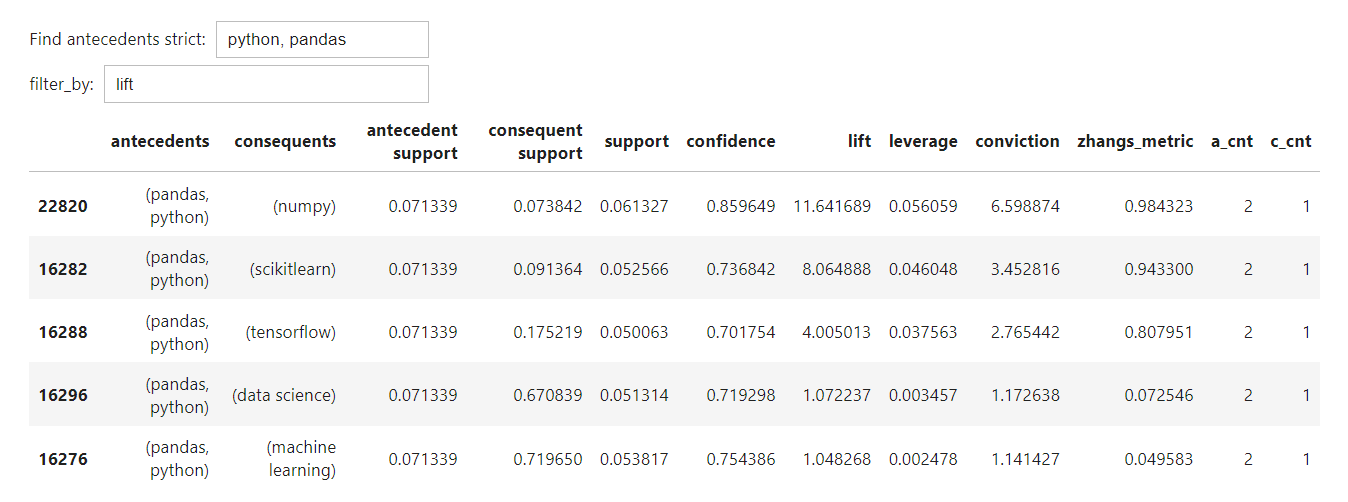

Support = 0.05

Comparing Hirability for:
- base `python, pandas`
- `python, pandas` plus 3 random skills
- `python, pandas` plus 3 skills recommended by fim with highest lift

In [12]:
base_skills = {'python', 'pandas'}

In [13]:
len(job_database)

799

### Base Case

In [14]:
x = get_skills_probability(job_database, base_skills)
print(f"{base_skills}\nHirability: {x}%\nJobs available: {round((x*len(job_database))/100)}")

{'pandas', 'python'}
Hirability: 3.7287%
Jobs available: 30


### Stochastic Case

Get hirability when `x` random skills are added to base case, have 100 iterations and get the average

In [15]:
prob_list = []
for i in range(100):
    choice = set([item for sublist in job_database['job_skills_'].tolist() for item in sublist])
    random_skill = random.sample(list(choice), 3)
    skills_to_match = base_skills.union(random_skill)
    prob_list.append(get_skills_probability(job_database, skills_to_match))
average = sum(prob_list) / len(prob_list)

print(f"""
{base_skills} plus 3 random skills, 100 iterations get average\nHirability: {round(average, 4)}%\nJobs available: {round((round(average, 4)*len(job_database))/100)}""")


{'pandas', 'python'} plus 3 random skills, 100 iterations get average
Hirability: 3.7972%
Jobs available: 30


### FIM Case

From the association rules above get top x skills consequents with highest lift and add to skills

In [16]:
fim_skills = base_skills.union({'numpy', 'scikit-learn', 'tensorflow'})
x = get_skills_probability(job_database, fim_skills)
print(f"{base_skills}\nHirability: {x}%\nJobs available: {round((x*len(job_database))/100)}")

{'pandas', 'python'}
Hirability: 4.6838%
Jobs available: 37


### Validation check if better

Result:
- 3.7287% (base)
- 3.7624% (random skill in all skills)
- 4.6838% (fim recommended with high lift)

Hirability increase better in fim case compared to stochastic case!

## Case 2 - Data Engineer to Tech Lead

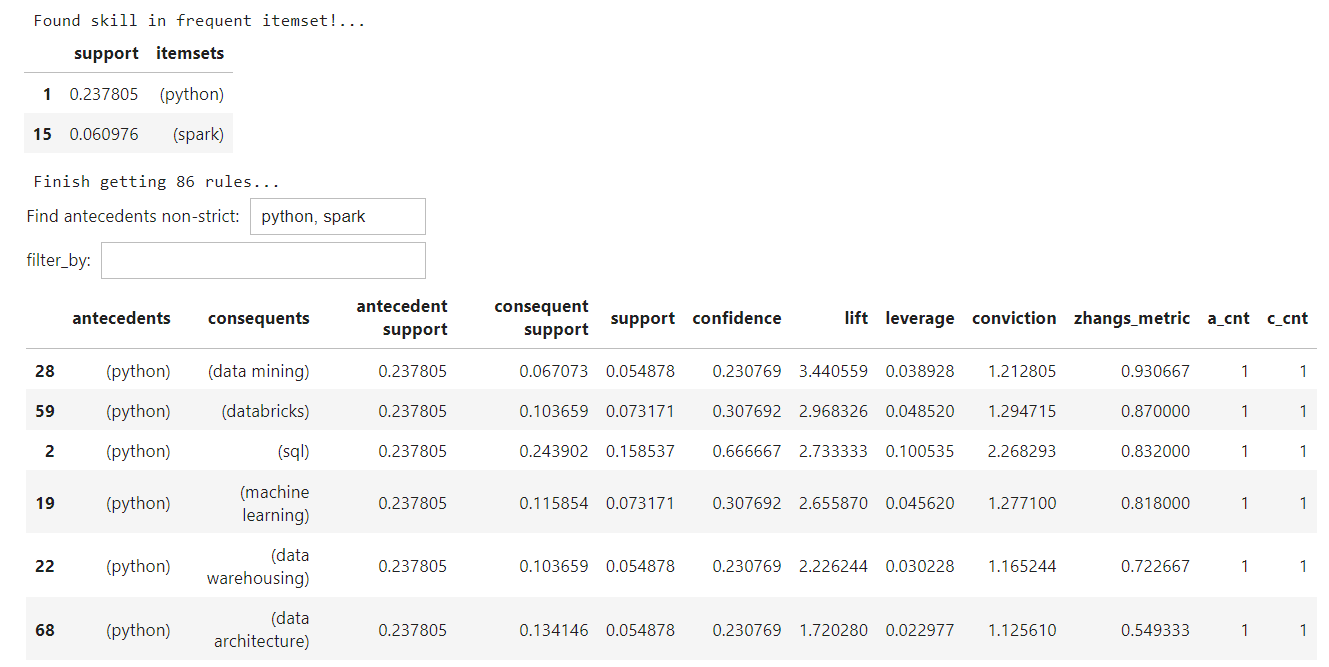

For case 2 for example a data engineer with python, spark and hadoop experience wants to be a Tech Lead
Hadoop is not found in Tech Lead's frequent itemset meaning hadoop skill has insignificant bearing on Tech Lead Role and will not produce association rule.

In [17]:
job_database = merged_df[merged_df['job_title_new'] == 'tech/data lead']

In [18]:
base_skills = {'python', 'spark', 'hadoop'}

### Base Case

In [19]:
print(f"{base_skills}\nHirability: {get_skills_probability(job_database, base_skills)}%")

{'spark', 'python', 'hadoop'}
Hirability: 1.3671%


### Stochastic Case

In [20]:
prob_list = []
for i in range(100):
    choice = set([item for sublist in job_database['job_skills_'].tolist() for item in sublist])
    random_skill = random.sample(list(choice), 3)
    skills_to_match = base_skills.union(random_skill)
    prob_list.append(get_skills_probability(job_database, skills_to_match))
average = sum(prob_list) / len(prob_list)

print(f"{base_skills} plus 3 random skills, 100 iterations get average\nHirability: {round(average, 4)}%")

{'spark', 'python', 'hadoop'} plus 3 random skills, 100 iterations get average
Hirability: 1.4729%


### FIM Case

In [21]:
fim_skills = base_skills.union({'data mining', 'databricks', 'machine learning'})
print(f"{fim_skills}\nHirability: {get_skills_probability(job_database, fim_skills)}%")

{'hadoop', 'machine learning', 'python', 'spark', 'databricks', 'data mining'}
Hirability: 2.4184%


### Validation check if better

Result:
- 1.2099% (base)
- 1.3184% (random skill in all skills)
- 2.2611% (fim recommended with high lift)

Hirability increase better in fim case compared to stochastic case!